Land cover is the bio-physical material present on the Earth's surface. For example - water bodies, forests, bare soil, man-made surfaces.

Land use is the purpose or activity of the surface for human consumption. For example - agriculture, residential, commercial, conservation.

Land cover can be analysed for desired geographical region through satelite imagery. The trend of changed land cover can be used to understand the pattern of land use, and plan accordingly.

While a standard photo uses only Red, Green, and Blue channels, multi-spectral satellites like [Sentinel-2](https://en.wikipedia.org/wiki/Sentinel-2) capture "invisible" light across 12 distinct spectral bands. These extra bands, such as Infrared, allow us to detect "spectral signatures" that differentiate materials - like grass versus green paint.

For machine learning, we reshape this data into a matrix where each of the  H×W  pixels is a sample and each band is a feature. This high-dimensional depth enables algorithms like K-Means to group land covers with far greater precision than standard 3-band imagery.

In [ ]:

import rasterio
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



PROJECT_ROOT = Path.cwd().parent
RAW_DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)

tiff_path = RAW_DATA_DIR / 'merged.tiff' # satellite very big file

# best practice: use a context manager so the file is always closed
with rasterio.open(tiff_path) as src:
    data = src.read()

# now data is 12 god arrays = 12 photographs and each photograph/array is a h*w matrix
# its a 3d numpy array/tensor
# so assuming 12 photos stacked left to right as red color = photo0, blue = photo1 and so on
# with each photo being its own 2d matrix  beffore reshape
# after reshape its 12 columsn of bands and each row is one sample = one pixel, shape (h*w,12)
# we arrange this way since ML convention is X (rows) = things you want to study (pixel/loc) and y (columns) = attributes of those things

print(f'\nRead data as matrix of shape {data.shape}')

#data
# means we have say a point at h,w like x,y which has 12 values (one for each color)

In [7]:
# TODO: update these values from the shape of the matrix

N, H, W = data.shape # simple easy, aka tuple unpacking

# reshape the data to (H x W, N)
# the data in a row should correspond to a pixel

# sanity check
#random_pixel = (118, 256) # (h, w) Output: Array of 12 numbers (one per band)
#display(data[:, random_pixel[0], random_pixel[1]])

# init it was N H W now we want H W N, simply like index of shape tuple
# without transpose wed get 12 pixels from Band 0, NOT 12 bands for Pixel 0
data = data.transpose(1, 2, 0).reshape(H * W, N)
#display(data[random_pixel[0] * W + random_pixel[1]])
data.shape

(4967500, 12)

visually

**og (bands, h,w)**

`Memory: [B0P0, B0P1, ..., B0P_last, B1P0, B1P1, ..., B11P_last]`

**after transpose (h,w, bands)**

`Memory: [P0B0, P0B1, ..., P0B11, P1B0, P1B1, ..., P_lastB11]`

**after reshape (h*w, bands)**
```
Row 0: [P0B0, P0B1, ..., P0B11]
Row 1: [P1B0, P1B1, ..., P1B11]
```



In [8]:
# TODO: import Pipeline, KMeans and StandardScaler from sklearn
# it is important to "normalize" the data before training (via std scaler)
# TODO: create a pipeline and use the "fit" method to train the model

k = 6  # choose number of land-cover clusters
pipeline = Pipeline([
    ("scaler", StandardScaler()),("kmeans", KMeans(n_clusters=k, random_state=42, n_init="auto"))
]).fit(data)


In [ ]:
# see the clusters and labels of the trained model
# plot the clusters by colors for each pixel
# visualize the map with colors

# named_steps is a dictionary-like attribute that allows you to access each specific component by the name you gave it (e.g., 'scaler' or 'kmeans').
clusters = pipeline.named_steps['kmeans']
labels = clusters.labels_ # TODO: update the labels from clusters

centers = clusters.cluster_centers_ # TODO: update the centers from clusters (useful for predictions)

# this center variable is a matrix of 6,12 with each row for each cluster and 12 col of each spectral band

# display(labels, centers)



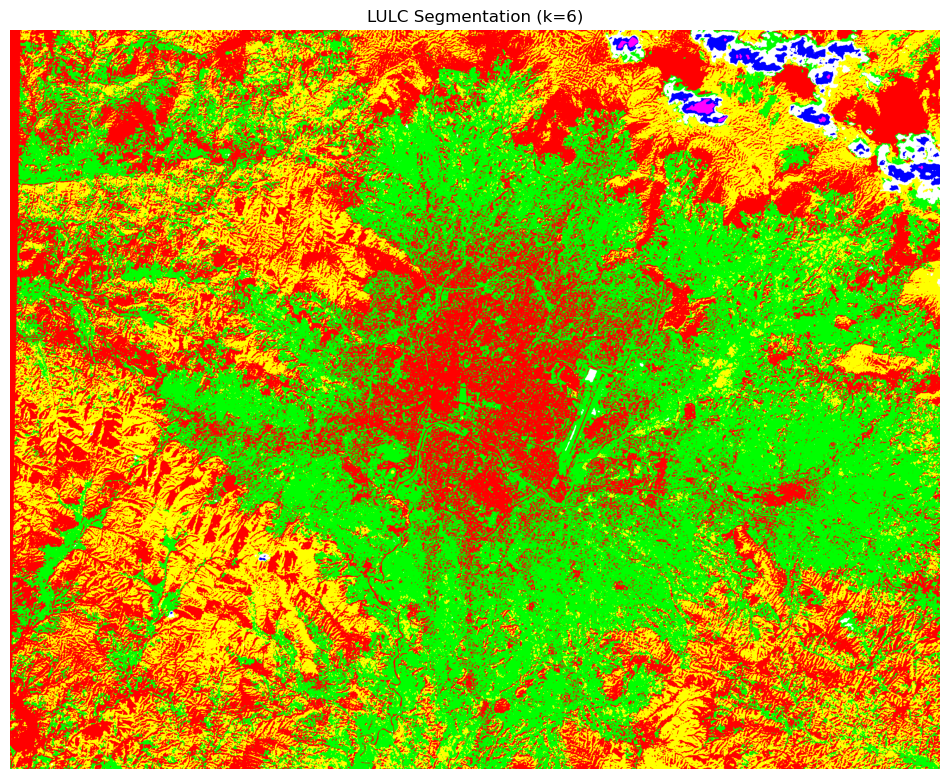

In [ ]:
# plot the clusters by colors for each pixel
# define colors for all pixels since if it happens to be critical such as 'bare soil' its catastrophic

colors = np.array([
  [255, 0, 0], # Red
  [0, 255, 0], # Green
  [0, 0, 255], # Blue
  [255, 255, 255], # White
  [255, 255, 0], # yellow
  [255, 0, 255]   #Magenta # Yellow
], dtype=np.uint8)

segmented_image = colors[labels].reshape(H, W, 3)
# we are converting 12D scientific result into 3 channel so our monitor can display

plt.figure(figsize=(12, 12))
plt.imshow(segmented_image)
plt.title(f'LULC Segmentation (k={k})')
plt.axis('off')
plt.show()

# must be able to correspond physical land cover with cluster index/color to make the model useful for risk assessment

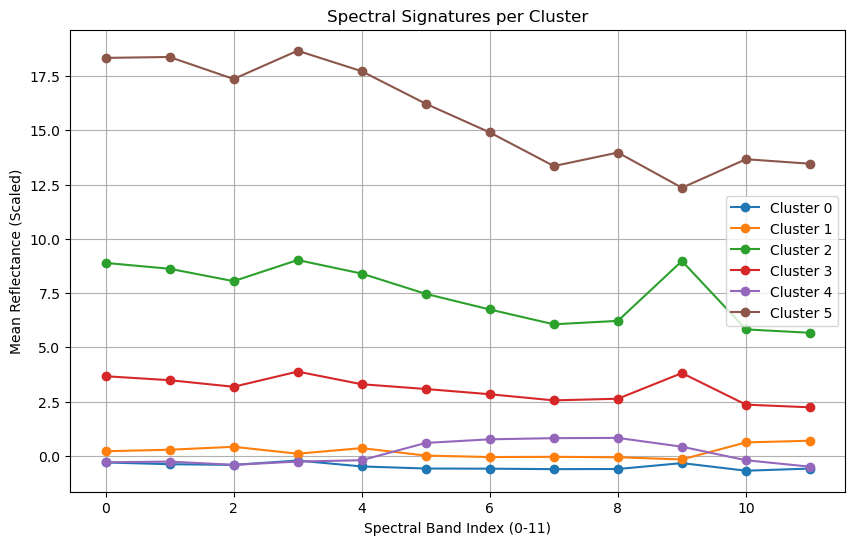

In [ ]:
#  VIZ
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.plot(centers[i], label=f'Cluster {i}', marker='o')

plt.xlabel('Spectral Band Index (0-11)')
plt.ylabel('Mean Reflectance (Scaled)')
plt.title('Spectral Signatures per Cluster')
plt.legend()
plt.grid(True)
plt.show()

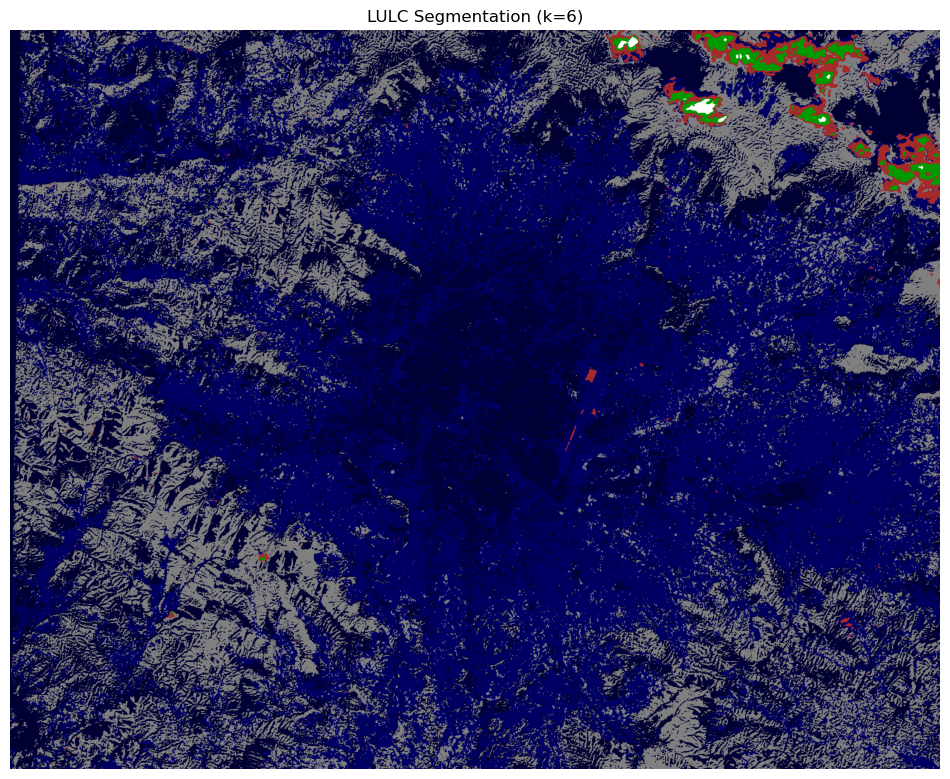

In [ ]:
# (Refined based on Spectral Signature Plot)
# 0 & 1: Low reflectance (Mountain Shadows/Water)
# 2: NIR Spike (Vegetation)
# 5: High overall reflectance (Likely Snow or Urban)

colors = np.array([
    [0, 0, 50],      # Cluster 0: Deep Shadow/Water (Dark Blue)
    [0, 0, 100],     # Cluster 1: Shadow/Water (Blue)
    [0, 155, 0],     # Cluster 2: VEGETATION (NIR Spike - Green)
    [165, 42, 42],   # Cluster 3: Bare Soil/Rock (Brown)
    [128, 128, 128], # Cluster 4: Mixed/Shadow (Grey)
    [255, 255, 255]  # Cluster 5: Snow/Clouds (White)
], dtype=np.uint8)

segmented_image = colors[labels].reshape(H, W, 3)
# we are converting 12D scientific result into 3 channel so our monitor can display

plt.figure(figsize=(12, 12))
plt.imshow(segmented_image)
plt.title(f'LULC Segmentation (k={k})')
plt.axis('off')
plt.show()

In [ ]:
unique_elements, counts = np.unique(labels, return_counts = True)
# equivalent to pandas value_counts

total_count = np.sum(counts)
percentages = 100 * counts / total_count

# enumerate takes a coll (list/array) and returns index+value from the coll
for i, pct in enumerate(percentages):
    display(f"Cluster {i}: {pct:.2f}% of total area")

'Cluster 0: 37.78% of total area'

'Cluster 1: 38.44% of total area'

'Cluster 2: 0.53% of total area'

'Cluster 3: 1.06% of total area'

'Cluster 4: 22.12% of total area'

'Cluster 5: 0.07% of total area'

**Is a "Percentage of Total Area" a valid metric for risk?**

C3 (bare soil) makees <1% of area, but if located on a 45 slope directly above silent, its critical. The model blindly suggests that its minimal risk since the area is small.
Knowing area is x tells us nothing of the actual risk.

- bare soil is earth stripped of vegetation
- it typically shows moderate reflectance across all bands—higher than water but lower than snows
- In Nepal, bare soil is rarely just "dirt." It is either Agricultural Land (temporary risk) or a Landslide Scar (active geological failure).
- Signatures for ubran areas and rocky soil are nearly identical

Concrete (Urban): Typically has very high reflectance in SWIR-1 (Index 10) and drops significantly in SWIR-2 (Index 11).

Rocky Soil/Bare Earth: Maintains a more consistent reflectance across both SWIR bands because of mineral moisture and geological composition.

We can use NDBuiltupI = swir-nir/swir+nir like NDvegetationI but for diff purpose
